# Customer Segmentation

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
pd.options.mode.chained_assignment = None  

## Preprocessing 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,QuantileTransformer

#
from pickle import dump,load

In [5]:
df = pd.read_csv("train-csv(1).txt");

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,others,5,may,261,1,-1,0.0,others,no
1,44,technician,single,secondary,no,29,yes,no,others,5,may,151,1,-1,0.0,others,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,others,5,may,76,1,-1,0.0,others,no
3,47,blue-collar,married,others,no,1506,yes,no,others,5,may,92,1,-1,0.0,others,no
4,33,others,single,others,no,1,no,no,others,5,may,198,1,-1,0.0,others,no


## Data Understanding

In [7]:
df_org = df[["age", "job", 'marital', 'education', 'balance', 'housing', 'loan',]]

In [8]:
df_org.describe()

,age,balance
count,45211.000000,45211.000000
mean,40.936210,1362.272058
std,10.618762,3044.765829
min,18.000000,-8019.000000
25%,33.000000,72.000000
50%,39.000000,448.000000
75%,48.000000,1428.000000
max,95.000000,102127.000000


In [9]:
df_org.job.value_counts().index

Index(['blue-collar', 'management', 'technician', 'admin.', 'services',
       'retired', 'self-employed', 'entrepreneur', 'unemployed', 'housemaid',
       'student', 'others'],
      dtype='object')

In [10]:
df_org.marital.value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [11]:
df_org.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
others        1857
Name: education, dtype: int64

In [12]:
df.housing.value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [13]:
df_org.loan.value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

## Data Preprocessing

In [14]:
df_org.drop(df_org[df_org.balance < 1].index, inplace = True)

In [15]:
StdScl = StandardScaler()
df_org['SS_balance'] = StdScl.fit_transform(df_org['balance'].values.reshape(-1,1))

In [16]:
df_org.drop(df_org[df_org.SS_balance > 3].index, inplace = True)

In [17]:
df_org.drop("SS_balance", axis = 1 , inplace = True)

In [18]:
df_original=df_org.copy()
print(df_original.shape,df_org.shape)

(37296, 7) (37296, 7)


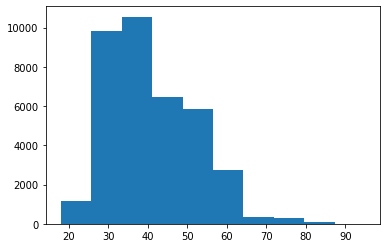

In [19]:
plt.hist(df_org['age'])
plt.show()

In [20]:
QT_age = QuantileTransformer(output_distribution='normal')
df_org['age'] = QT_age.fit_transform(df_org['age'].values.reshape(-1,1))

dump(QT_age, open('QT_age.pkl', 'wb'))


In [21]:
df_org.columns

Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan'], dtype='object')

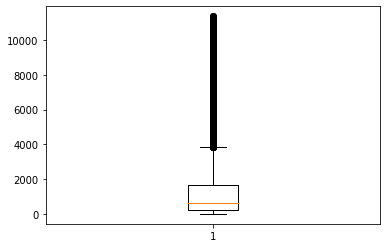

In [22]:
plt.boxplot(df_org.balance)
plt.show()

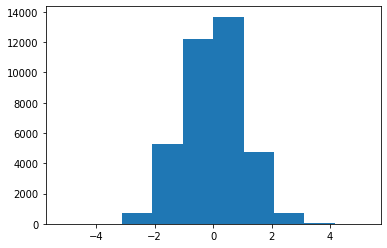

In [23]:
plt.hist(df_org['age'])
plt.show()

In [24]:
QT_balance = QuantileTransformer(output_distribution='normal')
df_org['balance'] = QT_balance.fit_transform(df_org['balance'].values.reshape(-1,1))

dump(QT_balance, open('QT_balance.pkl', 'wb'))

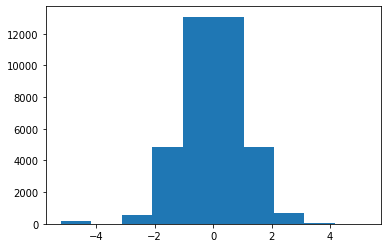

In [25]:
plt.hist(df_org['balance'])
plt.show()

In [26]:
#["age", "job", 'marital', 'education', 'balance', 'housing', 'loan',]
transformer = ColumnTransformer(transformers = [
    ('tnf1',OneHotEncoder(sparse = True, drop = 'first'),['job','marital',]),
    ('tnf2', MinMaxScaler(), ['balance','age',]  ),
    ('tnf3', OrdinalEncoder(categories= [(["others","primary", "secondary",'tertiary',])]),['education',]),  
    ('tnf4', OrdinalEncoder(categories= [(["no","yes",])]),['housing',]),
    ('tnf5', OrdinalEncoder(categories= [(["no","yes",])]),['loan',]),
], remainder= 'passthrough')


In [27]:
df_org = transformer.fit_transform(df_org)

dump(transformer, open('transformer.pkl', 'wb'))


In [28]:
df_org.shape

(37296, 18)

## Modeling

In [29]:
from sklearn.cluster import KMeans
from sklearn import metrics

for n_clusters in range(10,11):

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, algorithm = 'elkan')
    kmeans = kmeans.fit(df_org)
    print("Silhouette Score = {}\n".format(metrics.silhouette_score(df_org,kmeans.labels_)))
    
    df_original.reset_index(inplace = True,drop = True)
    result = pd.concat([df_original, pd.DataFrame({'cluster':kmeans.labels_})],axis=1,)
    result = result.sort_values(by=['cluster'], ascending=[True])
    #result.drop('index',axis = 1, inplace = True)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):    

      print('{}\t{}\t\t{}'.format('Cluster', 'Age', 'Balance'))
      print('{}'.format('-' * 80))
      for cluster in result.cluster.unique():
        print('{}\t{:.2f} ({:.2f})\t{:.2f} ({:.2f})\t'.format
        (cluster, result[result.cluster==cluster].age.mean()
        , result[result.cluster==cluster].age.std()
        , result[result.cluster==cluster].balance.mean()
        , result[result.cluster==cluster].balance.std()))
        print('{}'.format('-' * 80))
        print()
        #plt.show()
        print('{}'.format('-' * 80))

dump(kmeans, open('kmeans.pkl', 'wb'))


Silhouette Score = 0.2539385482902277

Cluster	Age		Balance
--------------------------------------------------------------------------------
0	47.49 (11.40)	1509.24 (1955.16)	
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
1	41.35 (8.56)	1210.78 (1671.47)	
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
2	42.19 (9.06)	1614.34 (2053.26)	
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
3	35.57 (8.50)	1118.46 (1633.70)	
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
4	32.78 (8.06)	1237.16 (1741.71)	
------------------------------------

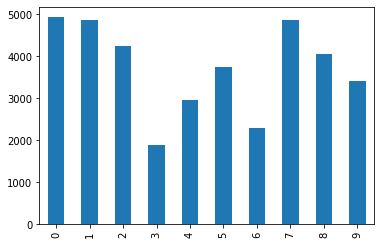

In [30]:
result.cluster.value_counts().sort_index().plot(kind = 'bar')

In [31]:
result

,age,job,marital,education,balance,housing,loan,cluster
37295,37,entrepreneur,married,secondary,2971,no,no,0
7928,52,management,divorced,secondary,944,no,yes,0
7927,56,services,divorced,secondary,450,no,no,0
20612,34,admin.,married,secondary,131,no,no,0
20614,29,blue-collar,married,secondary,659,no,no,0
...,...,...,...,...,...,...,...,...
27213,30,technician,single,secondary,3313,yes,no,9
33805,34,services,single,secondary,528,yes,no,9
27216,32,services,single,secondary,48,yes,no,9
1720,40,services,single,secondary,737,yes,no,9


In [32]:
result.sort_index()

,age,job,marital,education,balance,housing,loan,cluster
0,58,management,married,tertiary,2143,yes,no,2
1,44,technician,single,secondary,29,yes,no,9
2,33,entrepreneur,married,secondary,2,yes,yes,7
3,47,blue-collar,married,others,1506,yes,no,8
4,33,others,single,others,1,no,no,8
...,...,...,...,...,...,...,...,...
37291,51,technician,married,tertiary,825,no,no,5
37292,71,retired,divorced,primary,1729,no,no,8
37293,72,retired,married,secondary,5715,no,no,0
37294,57,blue-collar,married,secondary,668,no,no,0


In [33]:
result.cluster.sort_values(ascending = False)

26042    9
23899    9
21714    9
6254     9
363      9
        ..
16842    0
10613    0
10612    0
16855    0
37295    0
Name: cluster, Length: 37296, dtype: int32

In [34]:
result.to_excel("z-score-output.xlsx",sheet_name='Sheet_name_1') 

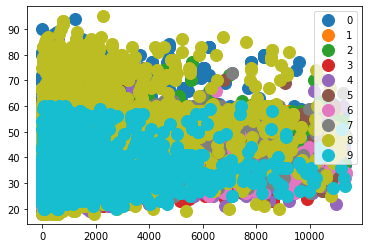

In [35]:
fig, ax = plt.subplots()
groups = result.groupby('cluster')
for name, group in groups:
  
    ax.plot(group.balance, group.age, marker='o', alpha = 1 , linestyle='', ms=12, label=name)
ax.legend()

plt.show()

## Evaluation

In [36]:
from yellowbrick.cluster import SilhouetteVisualizer

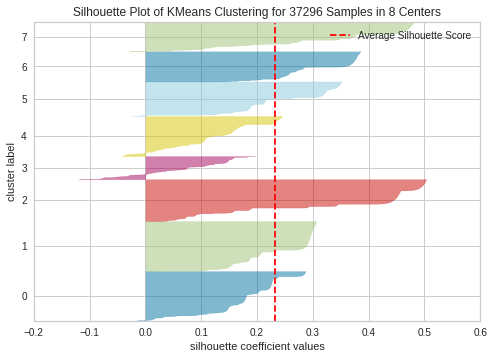

In [37]:
model = KMeans(n_clusters=8, random_state=0, algorithm = 'elkan')
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(df_org)        # Fit the data to the visualizer
visualizer.show()

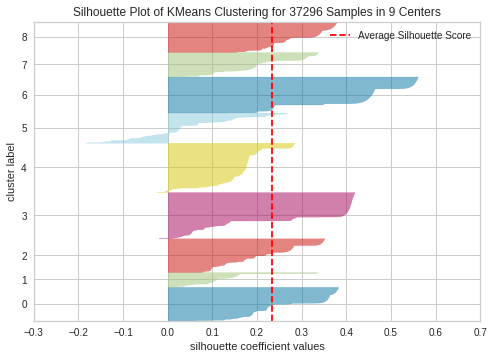

In [38]:
model = KMeans(n_clusters=9, random_state=0, algorithm = 'elkan')
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(df_org)        # Fit the data to the visualizer
visualizer.show()

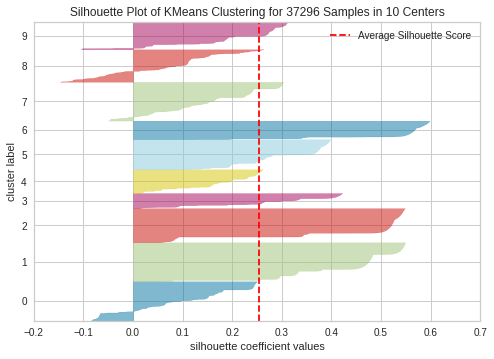

In [39]:
model = KMeans(n_clusters=10, random_state=0, algorithm = 'elkan')
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(df_org)        # Fit the data to the visualizer
visualizer.show()

## Model Saving

In [40]:
QT_balance = load(open('QT_balance.pkl', 'rb'))
QT_age = load(open('QT_age.pkl', 'rb'))
transformer_file = load(open('transformer.pkl', 'rb'))
kmeans_file = load(open('kmeans.pkl', 'rb'))


In [41]:
temp = df_original.head(1)
# temp = df_original.iloc[0,:]
temp


,age,job,marital,education,balance,housing,loan
0,58,management,married,tertiary,2143,yes,no


In [42]:
temp['balance'] = QT_balance.transform(temp['balance'].values.reshape(-1,1))
temp['age'] = QT_age.transform(temp['age'].values.reshape(-1,1))
temp = transformer_file.transform(temp)
answer = kmeans_file.predict(temp)
print(temp)
print(answer)
#print(kmeans.predict(temp))


[[0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         1.
  0.         0.58178674 0.64480181 3.         1.         0.        ]]
[2]


## EDA of Clusters

In [43]:
cluster1 = result[result.cluster == 1]

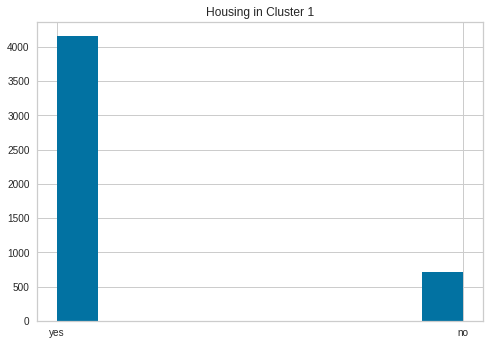

In [44]:
plt.hist(cluster1.housing)
plt.title("Housing in Cluster 1")
plt.show()

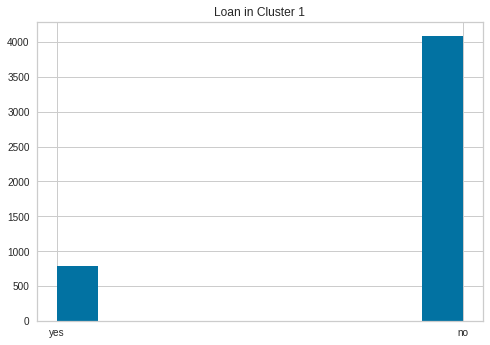

In [45]:
plt.hist(cluster1.loan)
plt.title("Loan in Cluster 1")
plt.show()

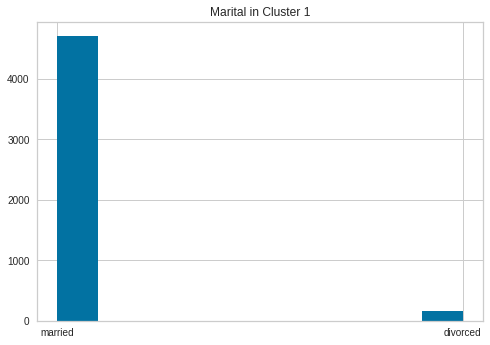

In [46]:
plt.hist(cluster1.marital)
plt.title("Marital in Cluster 1")
plt.show()

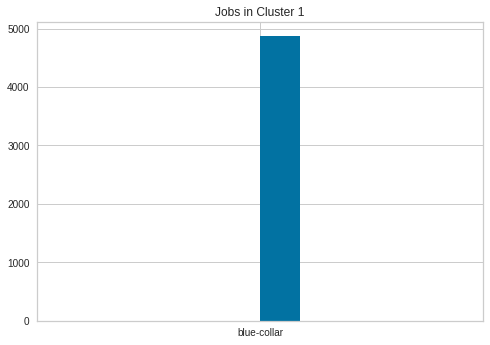

In [47]:
plt.hist(cluster1.job)
plt.title("Jobs in Cluster 1")
plt.show()

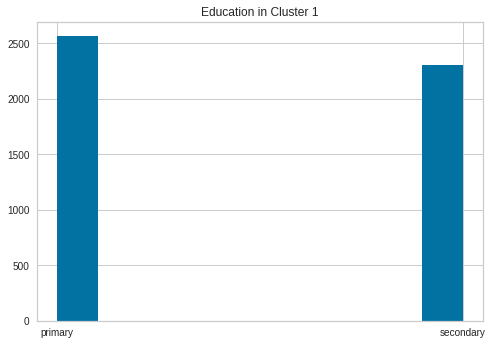

In [48]:
plt.hist(cluster1.education)
plt.title("Education in Cluster 1")
plt.show()

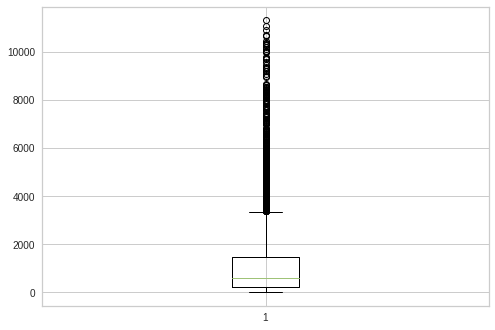

In [49]:
plt.boxplot(cluster1.balance)
plt.show()

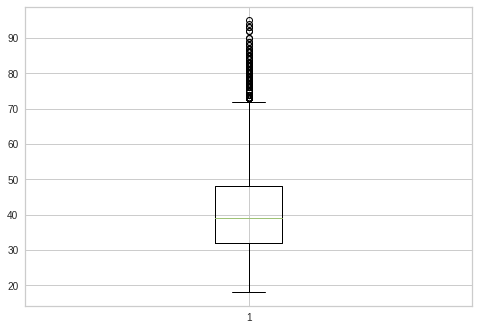

In [50]:
plt.boxplot(result.age)
plt.show()

In [51]:
cluster6 = result[result.cluster == 6]

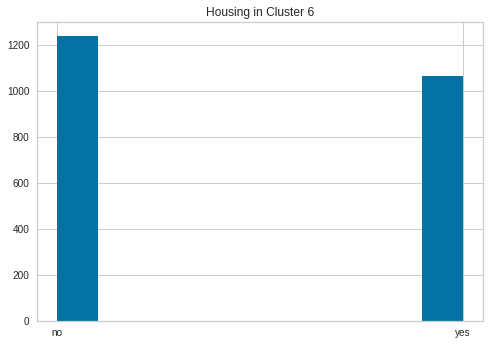

In [52]:
plt.hist(cluster6.housing)
plt.title("Housing in Cluster 6")
plt.show()

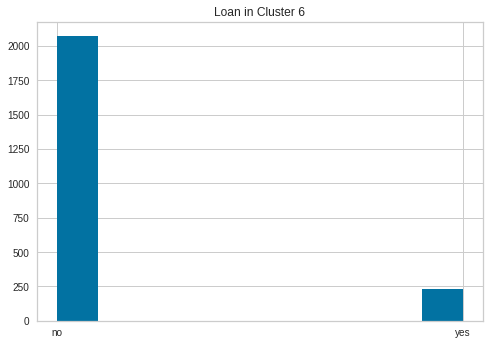

In [53]:
plt.hist(cluster6.loan)
plt.title("Loan in Cluster 6")
plt.show()

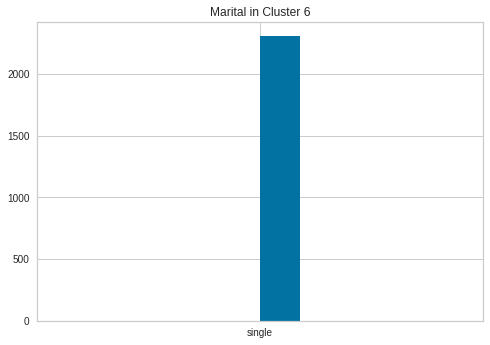

In [54]:
plt.hist(cluster6.marital)
plt.title("Marital in Cluster 6")
plt.show()

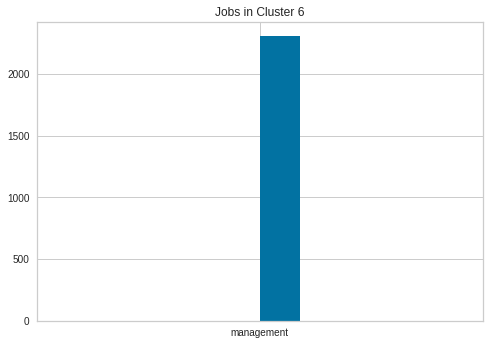

In [55]:
plt.hist(cluster6.job)
plt.title("Jobs in Cluster 6")
plt.show()

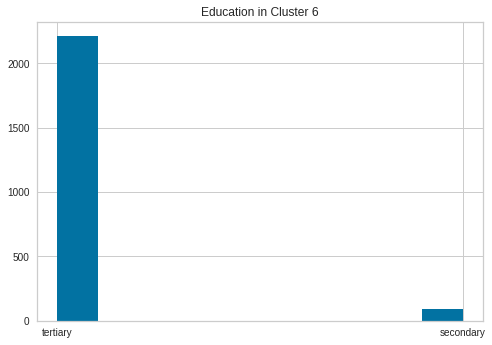

In [56]:
plt.hist(cluster6.education)
plt.title("Education in Cluster 6")
plt.show()